In [12]:
import numpy as np
import matplotlib.pyplot as plt

class MLP:
    def __init__(self, layer_sizes, transfer_functions):
        # Check the number of layers
        assert len(layer_sizes) - 1 == len(transfer_functions), "Number of hidden layers and transfer functions must be the same"
        assert len(layer_sizes) > 1 and len(layer_sizes) <= 4, "Number of layers should be between 2 and 4"

        # Set random seed for reproducibility
        np.random.seed(42)

        # Initialize network structure
        self.layer_sizes = layer_sizes
        self.transfer_functions = transfer_functions

        # Initialize weights and biases
        self.weights = [np.random.uniform(-2.0, 2.0, (layer_sizes[i+1], layer_sizes[i])) for i in range(len(layer_sizes)-1)]
        self.biases = [np.random.uniform(-2.0, 2.0, (layer_sizes[i+1], 1)) for i in range(len(layer_sizes)-1)]

    def __sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def __sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def __tanh_derivative(self, x):
        return 1 - x**2
    
    def get_activation_function(self, input, function_name):
        match function_name:
            case 'logistic':
                return self.__sigmoid(input)
            case 'tanh': 
                return np.tanh(input)
            case 'identity': 
                return input
            
    def get_activation_function_gradient(self, input, function_name):
        match function_name:
            case 'logistic':
                return self.__sigmoid_derivative(input)
            case 'tanh': 
                return 1 - self.__tanh_derivative(input)
            case 'identity': 
                return 1

    def forward(self, inputs):
        self.activations = [inputs] # Treat it as input values, it has not been passed through activation yet.
        self.weighted_sums = []
        for i in range(len(self.layer_sizes)-1):
            weighted_sum = np.dot(self.weights[i], self.activations[i]) + self.biases[i] # Calculating weighted sum by multiplying weights and outputs from previous layer + biases
            activation = self.get_activation_function(weighted_sum, self.transfer_functions[i]) # Passing weighted sum through activation function
            self.activations.append(activation) # appending the output, which will be later used as an input to the next layer

        return self.activations[-1]

    def backward(self, inputs, targets, learning_rates):
        errors = [self.activations[-1] - targets]
        deltas = [errors[-1] * self.get_activation_function_gradient(self.activations[-1], self.transfer_functions[-1])] # delta value for output neuron

        for i in reversed(range(len(self.layer_sizes)-2)):
            error = np.dot(self.weights[i+1].T, deltas[0])
            errors.insert(0, error) # insert error for a given layer at the front.
            delta = errors[0] * self.get_activation_function_gradient(self.activations[i+1], self.transfer_functions[i]) # delta value for hidden neuron
            deltas.insert(0, delta) # insert deltas for a given layer at the front.

        # Update weights and biases
        for i in range(len(self.layer_sizes)-1):
            self.weights[i] -= learning_rates[i] * np.dot(deltas[i], self.activations[i].T) # applying delta rule 
            self.biases[i] -= learning_rates[i] * deltas[i]

    def mean_squared_error(self, targets):
        return np.mean((targets - self.activations[-1])**2)

    def train(self, inputs, targets, epochs, learning_rates):
        learning_curve = []

        for epoch in range(epochs):
            total_error = 0

            for i in range(len(inputs)):
                input_data = np.array(inputs[i]).reshape(-1, 1)
                target_data = np.array(targets[i]).reshape(-1, 1)

                # Forward pass
                self.forward(input_data)

                # Calculate error
                error = self.mean_squared_error(target_data)
                total_error += error

                # Backward pass
                self.backward(input_data, target_data, learning_rates)

            mean_error = total_error / len(inputs)
            learning_curve.append(mean_error)

            print(f"Epoch {epoch+1}/{epochs}, Mean Squared Error: {mean_error}")

        # Saving to the file
        with open("learning_curve.txt", "w") as lc_file:
            lc_file.write("\n".join(map(str, learning_curve)))

    def test(self, test_inputs, test_targets):
        predictions = self.predict(test_inputs)
        test_error = np.mean((test_targets - predictions)**2)
        print(f"\nTest Mean Squared Error: {test_error}")

    def predict(self, inputs):
        predictions = []
        for i in range(len(inputs)):
            input_data = np.array(inputs[i]).reshape(-1, 1)
            output = self.forward(input_data)
            predictions.append(output.flatten())
        return predictions
    
def load_data(path):
    with open(path, 'r') as file:
        file.readline()

        parameters = file.readline().split()

        P, N, M = map(lambda x: int(x.split('=')[1]), parameters[1:])

        data = np.loadtxt(file, dtype=np.dtype(np.float64))
    #data = np.subtract(data, 0.1) #for some reason, 0.1 is added to all values in the file?
    # Extract input and output matrices
    input_matrix = data[:, :N]
    output_matrix = data[:, N:]

    return input_matrix, output_matrix, P, N, M

In [13]:
# Set network parameters
path = "PA-A_training_data_03.txt"
test_path = "test_data.txt" # Test data is similar in structure to the training data. Input in range (0, 1), output (-1, 1)
X_test, Y_test, _, _, _ = load_data(path=test_path)
X_train, Y_train, P, N, M = load_data(path=path)

layer_sizes = [N, 100, 20, M]  # Number of neurons in each layer, where N is input layer size and M is output layer size
transfer_functions = ['logistic', 'logistic', 'tanh']  # Transfer function for each layer except input layer
learning_rates = [0.1, 0.005, 0.001] # In the lecture it was said learning rate for earlier layers can be higher than latter ones - we tested that

The choice of activation functions is pretty logical, since input data is between range 0 - 1, so sigmoid activation is perfect. The output is in range -1 and 1, thus tanh was chosen as the last activation.

Epoch 1/10000, Mean Squared Error: 1.1842966334040903
Epoch 2/10000, Mean Squared Error: 1.119946604877562
Epoch 3/10000, Mean Squared Error: 1.061011783916767
Epoch 4/10000, Mean Squared Error: 1.0279331904384654
Epoch 5/10000, Mean Squared Error: 1.0055087365618567
Epoch 6/10000, Mean Squared Error: 0.9879175784627159
Epoch 7/10000, Mean Squared Error: 0.970789020270927
Epoch 8/10000, Mean Squared Error: 0.9529523220949134
Epoch 9/10000, Mean Squared Error: 0.934758674458098
Epoch 10/10000, Mean Squared Error: 0.9167560542026352
Epoch 11/10000, Mean Squared Error: 0.8992574175070035
Epoch 12/10000, Mean Squared Error: 0.8823387737614429
Epoch 13/10000, Mean Squared Error: 0.8660561495170037
Epoch 14/10000, Mean Squared Error: 0.8505582984478931
Epoch 15/10000, Mean Squared Error: 0.8359890073507379
Epoch 16/10000, Mean Squared Error: 0.8223500597949538
Epoch 17/10000, Mean Squared Error: 0.8095116747988024
Epoch 18/10000, Mean Squared Error: 0.7973167284182469
Epoch 19/10000, Mean Sq

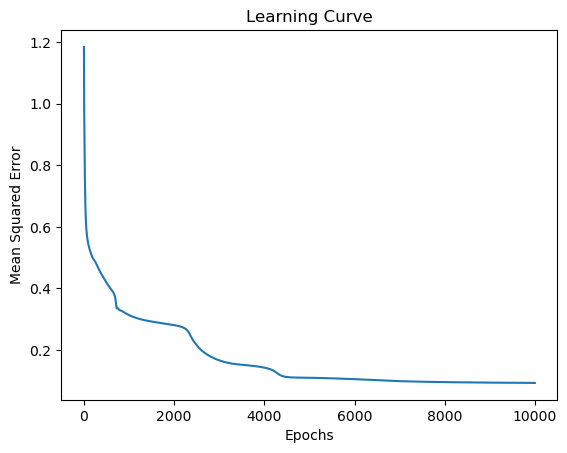

In [14]:
mlp = MLP(layer_sizes, transfer_functions)

# Train
mlp.train(X_train, Y_train, epochs=10000, learning_rates = learning_rates)

# Test
mlp.test(X_test, Y_test)

# Plot learning curve
learning_curve = np.loadtxt("learning_curve.txt")
plt.plot(learning_curve)
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.show()

Learning process has been ended successfully. Mean square error converges to a value around 0.09. Based on the plot and MSE values, we can say that the model has been trained